In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
import seaborn as sns
sns.set(color_codes=True)

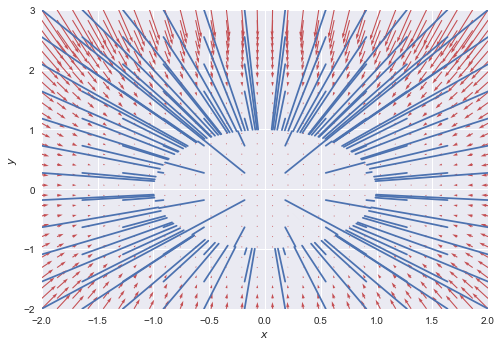

In [2]:
## ring attractor
np.random.seed(23)

def f(h, t):
    x, y = h
    s1 = -(x**2 + y**2 -1)*x
    s2 = -(x**2 + y**2 -1)*y
    return [s1, s2]


x = np.linspace(-2, 2, 30)
y = np.linspace(-2, 3, 30)


X, Y = np.meshgrid(x, y)


t = 0
u, v = np.zeros(X.shape), np.zeros(Y.shape)
NI, NJ = X.shape


# plot the arrows
for i in range(NI):
    for j in range(NJ):
        x = X[i, j]
        y = Y[i, j]
        yprime = f([x, y], t)
        u[i,j] = yprime[0]
        v[i,j] = yprime[1]
     

Q = plt.quiver(X, Y, u, v, color='r')

plt.xlabel('$x$')
plt.ylabel('$y$')
plt.xlim([-2, 2])
plt.ylim([-2, 3])

plot_param_traj_t = np.linspace(0, 10, 100)
plot_param_traj_x = np.linspace(-2, 2, 12)
plot_param_traj_y = np.linspace(-2, 3, 12)


for x0 in plot_param_traj_x:
    for y0 in plot_param_traj_y:
        x0 = float(x0)
        y0 = float(y0)
        n0 = [x0, y0]
        ys = odeint(f, n0, plot_param_traj_t)
        plt.plot(ys[:,0], ys[:,1], 'b-') # path
        plt.xlim([-2, 2])
        plt.ylim([-2, 3])

plt.show()


In [3]:
# data generation
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from __future__ import print_function
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from torch.autograd import Variable



np.random.seed(2)
N = 670
D = 2
L = 30
step_size = 0.006
learning_rate = 1e-3
n_epochs = 4000
batch_size = 60

input_size = 2 
hidden_size = 2
output_size = 2


########## data generation
n0 = np.random.uniform(-2, 3, (N, D))
t = np.linspace(0, step_size*L, L)

def integration_solver(a):
    a0 = [float(a[0]),float(a[1])]
    return odeint(f, a0, t)

data = np.apply_along_axis(integration_solver, 1, n0)    #(670, 30, 2)
data = data + np.random.normal(0, 0.01, size = data.shape)



########## input vs target, training test split  (input x1, target x2, x3, ... , x30)
train_input = Variable(torch.from_numpy(data[3:, :1, :])).type(torch.FloatTensor)
train_target = Variable(torch.from_numpy(data[3:, 1:, :])).type(torch.FloatTensor)
test_input = Variable(torch.from_numpy(data[:3, :1, :])).type(torch.FloatTensor)
test_target = Variable(torch.from_numpy(data[:3, 1:, :])).type(torch.FloatTensor)

## reshape to  (seq_length, sample_size, input_dim)
train_input = train_input.view(1,-1,2)
test_input = test_input.view(1,-1,2)




########### GRU models
class Sequence(nn.Module):
    def __init__(self):
        super(Sequence, self).__init__()
        self.gru = nn.GRUCell(input_size = input_size, hidden_size = hidden_size)
        self.linear = nn.Linear(hidden_size, output_size)
             
#     def forward(self, dat_input):     #(seq_length, sample_size, input_dim)
#         outputs = []
#         h0 = Variable(torch.zeros(dat_input.size(1), hidden_size))
#         for i in range(29):
#             h0 = self.gru(dat_input.view(-1,input_size), h0)
#             output = self.linear(h0)
#             outputs.append(output)
        
#         outputs = torch.stack(outputs, 1).squeeze(2)
#         return(outputs)                # 3, 29, 2 - (sample_size, seq_length, out_dim)
    
    def forward(self, dat_input):     #(seq_length, sample_size, input_dim)
        outputs = []
        h0 = Variable(torch.zeros(dat_input.size(1), hidden_size))
        a0 = dat_input.view(-1,input_size)
        for i in range(29):
            h0 = self.gru(a0, h0)
            output = self.linear(h0)
            a0 = output.view(-1, input_size)
            outputs.append(output)
        
        outputs = torch.stack(outputs, 1).squeeze(2)
        return(outputs)                # 3, 29, 2 - (sample_size, seq_length, out_dim)

model = Sequence()
print(model)

optimizer = optim.Adam(model.parameters(), lr = learning_rate)
criterion = nn.MSELoss()


def train(epoch):
    model.train()
    train_loss = 0    
    #idx = np.random.permutation(X_train.shape[0])
    idx = np.random.permutation(train_input.size()[1])
    j = 0
    while j < train_input.size()[1]:
        if j < train_input.size()[1] - batch_size:
            X_train = train_input[:,idx[j:(j + batch_size)],:]
            Y_train = train_target[idx[j:(j + batch_size)],:,:]
        else:
            X_train = train_input[:,idx[j:],:]
            Y_train = train_target[idx[j:],:,:]
            
        optimizer.zero_grad()
        out = model(X_train)
        loss = criterion(out, Y_train)
        loss.backward()      
        train_loss = loss.data[0]
        optimizer.step()
        j += batch_size
    return train_loss*1.0 / train_input.size()[1]


for epoch in range(1, n_epochs + 1):
    train_loss = train(epoch)
    print('====> Epoch: %d training loss: %.4f'%(epoch, train_loss))


# model (extract the model parameters)





Sequence(
  (gru): GRUCell(2, 2)
  (linear): Linear(in_features=2, out_features=2, bias=True)
)
====> Epoch: 1 training loss: 0.0022
====> Epoch: 2 training loss: 0.0021
====> Epoch: 3 training loss: 0.0020
====> Epoch: 4 training loss: 0.0024
====> Epoch: 5 training loss: 0.0022
====> Epoch: 6 training loss: 0.0012
====> Epoch: 7 training loss: 0.0029
====> Epoch: 8 training loss: 0.0021
====> Epoch: 9 training loss: 0.0021
====> Epoch: 10 training loss: 0.0010
====> Epoch: 11 training loss: 0.0026
====> Epoch: 12 training loss: 0.0021
====> Epoch: 13 training loss: 0.0016
====> Epoch: 14 training loss: 0.0012
====> Epoch: 15 training loss: 0.0016
====> Epoch: 16 training loss: 0.0019
====> Epoch: 17 training loss: 0.0016
====> Epoch: 18 training loss: 0.0014
====> Epoch: 19 training loss: 0.0011
====> Epoch: 20 training loss: 0.0009
====> Epoch: 21 training loss: 0.0011
====> Epoch: 22 training loss: 0.0010
====> Epoch: 23 training loss: 0.0011
====> Epoch: 24 training loss: 0.0014
=

====> Epoch: 212 training loss: 0.0006
====> Epoch: 213 training loss: 0.0006
====> Epoch: 214 training loss: 0.0008
====> Epoch: 215 training loss: 0.0006
====> Epoch: 216 training loss: 0.0009
====> Epoch: 217 training loss: 0.0007
====> Epoch: 218 training loss: 0.0003
====> Epoch: 219 training loss: 0.0005
====> Epoch: 220 training loss: 0.0008
====> Epoch: 221 training loss: 0.0016
====> Epoch: 222 training loss: 0.0010
====> Epoch: 223 training loss: 0.0010
====> Epoch: 224 training loss: 0.0008
====> Epoch: 225 training loss: 0.0008
====> Epoch: 226 training loss: 0.0007
====> Epoch: 227 training loss: 0.0009
====> Epoch: 228 training loss: 0.0009
====> Epoch: 229 training loss: 0.0011
====> Epoch: 230 training loss: 0.0005
====> Epoch: 231 training loss: 0.0005
====> Epoch: 232 training loss: 0.0006
====> Epoch: 233 training loss: 0.0004
====> Epoch: 234 training loss: 0.0007
====> Epoch: 235 training loss: 0.0007
====> Epoch: 236 training loss: 0.0007
====> Epoch: 237 training

====> Epoch: 424 training loss: 0.0002
====> Epoch: 425 training loss: 0.0003
====> Epoch: 426 training loss: 0.0002
====> Epoch: 427 training loss: 0.0003
====> Epoch: 428 training loss: 0.0005
====> Epoch: 429 training loss: 0.0002
====> Epoch: 430 training loss: 0.0001
====> Epoch: 431 training loss: 0.0002
====> Epoch: 432 training loss: 0.0003
====> Epoch: 433 training loss: 0.0002
====> Epoch: 434 training loss: 0.0002
====> Epoch: 435 training loss: 0.0003
====> Epoch: 436 training loss: 0.0003
====> Epoch: 437 training loss: 0.0002
====> Epoch: 438 training loss: 0.0003
====> Epoch: 439 training loss: 0.0002
====> Epoch: 440 training loss: 0.0002
====> Epoch: 441 training loss: 0.0003
====> Epoch: 442 training loss: 0.0002
====> Epoch: 443 training loss: 0.0001
====> Epoch: 444 training loss: 0.0001
====> Epoch: 445 training loss: 0.0002
====> Epoch: 446 training loss: 0.0002
====> Epoch: 447 training loss: 0.0001
====> Epoch: 448 training loss: 0.0003
====> Epoch: 449 training

====> Epoch: 635 training loss: 0.0001
====> Epoch: 636 training loss: 0.0002
====> Epoch: 637 training loss: 0.0001
====> Epoch: 638 training loss: 0.0001
====> Epoch: 639 training loss: 0.0002
====> Epoch: 640 training loss: 0.0002
====> Epoch: 641 training loss: 0.0001
====> Epoch: 642 training loss: 0.0001
====> Epoch: 643 training loss: 0.0001
====> Epoch: 644 training loss: 0.0001
====> Epoch: 645 training loss: 0.0002
====> Epoch: 646 training loss: 0.0002
====> Epoch: 647 training loss: 0.0002
====> Epoch: 648 training loss: 0.0001
====> Epoch: 649 training loss: 0.0001
====> Epoch: 650 training loss: 0.0002
====> Epoch: 651 training loss: 0.0001
====> Epoch: 652 training loss: 0.0002
====> Epoch: 653 training loss: 0.0002
====> Epoch: 654 training loss: 0.0001
====> Epoch: 655 training loss: 0.0002
====> Epoch: 656 training loss: 0.0001
====> Epoch: 657 training loss: 0.0002
====> Epoch: 658 training loss: 0.0002
====> Epoch: 659 training loss: 0.0002
====> Epoch: 660 training

====> Epoch: 845 training loss: 0.0001
====> Epoch: 846 training loss: 0.0001
====> Epoch: 847 training loss: 0.0001
====> Epoch: 848 training loss: 0.0001
====> Epoch: 849 training loss: 0.0001
====> Epoch: 850 training loss: 0.0001
====> Epoch: 851 training loss: 0.0001
====> Epoch: 852 training loss: 0.0001
====> Epoch: 853 training loss: 0.0001
====> Epoch: 854 training loss: 0.0001
====> Epoch: 855 training loss: 0.0001
====> Epoch: 856 training loss: 0.0001
====> Epoch: 857 training loss: 0.0001
====> Epoch: 858 training loss: 0.0001
====> Epoch: 859 training loss: 0.0001
====> Epoch: 860 training loss: 0.0001
====> Epoch: 861 training loss: 0.0001
====> Epoch: 862 training loss: 0.0001
====> Epoch: 863 training loss: 0.0001
====> Epoch: 864 training loss: 0.0001
====> Epoch: 865 training loss: 0.0001
====> Epoch: 866 training loss: 0.0001
====> Epoch: 867 training loss: 0.0000
====> Epoch: 868 training loss: 0.0001
====> Epoch: 869 training loss: 0.0001
====> Epoch: 870 training

====> Epoch: 1055 training loss: 0.0001
====> Epoch: 1056 training loss: 0.0001
====> Epoch: 1057 training loss: 0.0000
====> Epoch: 1058 training loss: 0.0001
====> Epoch: 1059 training loss: 0.0000
====> Epoch: 1060 training loss: 0.0001
====> Epoch: 1061 training loss: 0.0001
====> Epoch: 1062 training loss: 0.0001
====> Epoch: 1063 training loss: 0.0001
====> Epoch: 1064 training loss: 0.0000
====> Epoch: 1065 training loss: 0.0001
====> Epoch: 1066 training loss: 0.0001
====> Epoch: 1067 training loss: 0.0001
====> Epoch: 1068 training loss: 0.0000
====> Epoch: 1069 training loss: 0.0000
====> Epoch: 1070 training loss: 0.0000
====> Epoch: 1071 training loss: 0.0000
====> Epoch: 1072 training loss: 0.0000
====> Epoch: 1073 training loss: 0.0000
====> Epoch: 1074 training loss: 0.0000
====> Epoch: 1075 training loss: 0.0000
====> Epoch: 1076 training loss: 0.0001
====> Epoch: 1077 training loss: 0.0001
====> Epoch: 1078 training loss: 0.0001
====> Epoch: 1079 training loss: 0.0001


====> Epoch: 1260 training loss: 0.0000
====> Epoch: 1261 training loss: 0.0000
====> Epoch: 1262 training loss: 0.0001
====> Epoch: 1263 training loss: 0.0000
====> Epoch: 1264 training loss: 0.0000
====> Epoch: 1265 training loss: 0.0000
====> Epoch: 1266 training loss: 0.0000
====> Epoch: 1267 training loss: 0.0000
====> Epoch: 1268 training loss: 0.0000
====> Epoch: 1269 training loss: 0.0000
====> Epoch: 1270 training loss: 0.0000
====> Epoch: 1271 training loss: 0.0001
====> Epoch: 1272 training loss: 0.0000
====> Epoch: 1273 training loss: 0.0001
====> Epoch: 1274 training loss: 0.0000
====> Epoch: 1275 training loss: 0.0000
====> Epoch: 1276 training loss: 0.0000
====> Epoch: 1277 training loss: 0.0001
====> Epoch: 1278 training loss: 0.0001
====> Epoch: 1279 training loss: 0.0001
====> Epoch: 1280 training loss: 0.0000
====> Epoch: 1281 training loss: 0.0000
====> Epoch: 1282 training loss: 0.0001
====> Epoch: 1283 training loss: 0.0000
====> Epoch: 1284 training loss: 0.0000


====> Epoch: 1465 training loss: 0.0000
====> Epoch: 1466 training loss: 0.0000
====> Epoch: 1467 training loss: 0.0000
====> Epoch: 1468 training loss: 0.0000
====> Epoch: 1469 training loss: 0.0000
====> Epoch: 1470 training loss: 0.0000
====> Epoch: 1471 training loss: 0.0000
====> Epoch: 1472 training loss: 0.0000
====> Epoch: 1473 training loss: 0.0000
====> Epoch: 1474 training loss: 0.0000
====> Epoch: 1475 training loss: 0.0000
====> Epoch: 1476 training loss: 0.0000
====> Epoch: 1477 training loss: 0.0001
====> Epoch: 1478 training loss: 0.0000
====> Epoch: 1479 training loss: 0.0000
====> Epoch: 1480 training loss: 0.0000
====> Epoch: 1481 training loss: 0.0000
====> Epoch: 1482 training loss: 0.0000
====> Epoch: 1483 training loss: 0.0000
====> Epoch: 1484 training loss: 0.0000
====> Epoch: 1485 training loss: 0.0000
====> Epoch: 1486 training loss: 0.0000
====> Epoch: 1487 training loss: 0.0000
====> Epoch: 1488 training loss: 0.0000
====> Epoch: 1489 training loss: 0.0000


====> Epoch: 1671 training loss: 0.0000
====> Epoch: 1672 training loss: 0.0000
====> Epoch: 1673 training loss: 0.0000
====> Epoch: 1674 training loss: 0.0000
====> Epoch: 1675 training loss: 0.0000
====> Epoch: 1676 training loss: 0.0000
====> Epoch: 1677 training loss: 0.0001
====> Epoch: 1678 training loss: 0.0000
====> Epoch: 1679 training loss: 0.0000
====> Epoch: 1680 training loss: 0.0000
====> Epoch: 1681 training loss: 0.0000
====> Epoch: 1682 training loss: 0.0000
====> Epoch: 1683 training loss: 0.0000
====> Epoch: 1684 training loss: 0.0000
====> Epoch: 1685 training loss: 0.0000
====> Epoch: 1686 training loss: 0.0000
====> Epoch: 1687 training loss: 0.0000
====> Epoch: 1688 training loss: 0.0000
====> Epoch: 1689 training loss: 0.0000
====> Epoch: 1690 training loss: 0.0000
====> Epoch: 1691 training loss: 0.0000
====> Epoch: 1692 training loss: 0.0000
====> Epoch: 1693 training loss: 0.0000
====> Epoch: 1694 training loss: 0.0000
====> Epoch: 1695 training loss: 0.0000


====> Epoch: 1877 training loss: 0.0000
====> Epoch: 1878 training loss: 0.0000
====> Epoch: 1879 training loss: 0.0000
====> Epoch: 1880 training loss: 0.0000
====> Epoch: 1881 training loss: 0.0000
====> Epoch: 1882 training loss: 0.0000
====> Epoch: 1883 training loss: 0.0000
====> Epoch: 1884 training loss: 0.0000
====> Epoch: 1885 training loss: 0.0000
====> Epoch: 1886 training loss: 0.0000
====> Epoch: 1887 training loss: 0.0000
====> Epoch: 1888 training loss: 0.0000
====> Epoch: 1889 training loss: 0.0000
====> Epoch: 1890 training loss: 0.0000
====> Epoch: 1891 training loss: 0.0000
====> Epoch: 1892 training loss: 0.0000
====> Epoch: 1893 training loss: 0.0000
====> Epoch: 1894 training loss: 0.0000
====> Epoch: 1895 training loss: 0.0000
====> Epoch: 1896 training loss: 0.0000
====> Epoch: 1897 training loss: 0.0000
====> Epoch: 1898 training loss: 0.0000
====> Epoch: 1899 training loss: 0.0000
====> Epoch: 1900 training loss: 0.0000
====> Epoch: 1901 training loss: 0.0000


====> Epoch: 2082 training loss: 0.0000
====> Epoch: 2083 training loss: 0.0000
====> Epoch: 2084 training loss: 0.0000
====> Epoch: 2085 training loss: 0.0000
====> Epoch: 2086 training loss: 0.0000
====> Epoch: 2087 training loss: 0.0000
====> Epoch: 2088 training loss: 0.0000
====> Epoch: 2089 training loss: 0.0000
====> Epoch: 2090 training loss: 0.0000
====> Epoch: 2091 training loss: 0.0000
====> Epoch: 2092 training loss: 0.0000
====> Epoch: 2093 training loss: 0.0000
====> Epoch: 2094 training loss: 0.0000
====> Epoch: 2095 training loss: 0.0000
====> Epoch: 2096 training loss: 0.0000
====> Epoch: 2097 training loss: 0.0000
====> Epoch: 2098 training loss: 0.0000
====> Epoch: 2099 training loss: 0.0000
====> Epoch: 2100 training loss: 0.0000
====> Epoch: 2101 training loss: 0.0000
====> Epoch: 2102 training loss: 0.0000
====> Epoch: 2103 training loss: 0.0000
====> Epoch: 2104 training loss: 0.0000
====> Epoch: 2105 training loss: 0.0000
====> Epoch: 2106 training loss: 0.0000


====> Epoch: 2288 training loss: 0.0000
====> Epoch: 2289 training loss: 0.0000
====> Epoch: 2290 training loss: 0.0000
====> Epoch: 2291 training loss: 0.0000
====> Epoch: 2292 training loss: 0.0000
====> Epoch: 2293 training loss: 0.0000
====> Epoch: 2294 training loss: 0.0000
====> Epoch: 2295 training loss: 0.0000
====> Epoch: 2296 training loss: 0.0000
====> Epoch: 2297 training loss: 0.0000
====> Epoch: 2298 training loss: 0.0000
====> Epoch: 2299 training loss: 0.0000
====> Epoch: 2300 training loss: 0.0000
====> Epoch: 2301 training loss: 0.0000
====> Epoch: 2302 training loss: 0.0000
====> Epoch: 2303 training loss: 0.0000
====> Epoch: 2304 training loss: 0.0000
====> Epoch: 2305 training loss: 0.0000
====> Epoch: 2306 training loss: 0.0000
====> Epoch: 2307 training loss: 0.0000
====> Epoch: 2308 training loss: 0.0000
====> Epoch: 2309 training loss: 0.0000
====> Epoch: 2310 training loss: 0.0000
====> Epoch: 2311 training loss: 0.0000
====> Epoch: 2312 training loss: 0.0000


====> Epoch: 2493 training loss: 0.0000
====> Epoch: 2494 training loss: 0.0000
====> Epoch: 2495 training loss: 0.0000
====> Epoch: 2496 training loss: 0.0000
====> Epoch: 2497 training loss: 0.0000
====> Epoch: 2498 training loss: 0.0000
====> Epoch: 2499 training loss: 0.0000
====> Epoch: 2500 training loss: 0.0000
====> Epoch: 2501 training loss: 0.0000
====> Epoch: 2502 training loss: 0.0000
====> Epoch: 2503 training loss: 0.0000
====> Epoch: 2504 training loss: 0.0000
====> Epoch: 2505 training loss: 0.0000
====> Epoch: 2506 training loss: 0.0000
====> Epoch: 2507 training loss: 0.0000
====> Epoch: 2508 training loss: 0.0000
====> Epoch: 2509 training loss: 0.0000
====> Epoch: 2510 training loss: 0.0000
====> Epoch: 2511 training loss: 0.0000
====> Epoch: 2512 training loss: 0.0000
====> Epoch: 2513 training loss: 0.0000
====> Epoch: 2514 training loss: 0.0000
====> Epoch: 2515 training loss: 0.0000
====> Epoch: 2516 training loss: 0.0000
====> Epoch: 2517 training loss: 0.0000


====> Epoch: 2699 training loss: 0.0000
====> Epoch: 2700 training loss: 0.0000
====> Epoch: 2701 training loss: 0.0000
====> Epoch: 2702 training loss: 0.0000
====> Epoch: 2703 training loss: 0.0000
====> Epoch: 2704 training loss: 0.0000
====> Epoch: 2705 training loss: 0.0000
====> Epoch: 2706 training loss: 0.0000
====> Epoch: 2707 training loss: 0.0000
====> Epoch: 2708 training loss: 0.0000
====> Epoch: 2709 training loss: 0.0000
====> Epoch: 2710 training loss: 0.0000
====> Epoch: 2711 training loss: 0.0000
====> Epoch: 2712 training loss: 0.0000
====> Epoch: 2713 training loss: 0.0000
====> Epoch: 2714 training loss: 0.0000
====> Epoch: 2715 training loss: 0.0000
====> Epoch: 2716 training loss: 0.0000
====> Epoch: 2717 training loss: 0.0000
====> Epoch: 2718 training loss: 0.0000
====> Epoch: 2719 training loss: 0.0000
====> Epoch: 2720 training loss: 0.0000
====> Epoch: 2721 training loss: 0.0000
====> Epoch: 2722 training loss: 0.0000
====> Epoch: 2723 training loss: 0.0000


====> Epoch: 2904 training loss: 0.0000
====> Epoch: 2905 training loss: 0.0000
====> Epoch: 2906 training loss: 0.0000
====> Epoch: 2907 training loss: 0.0000
====> Epoch: 2908 training loss: 0.0000
====> Epoch: 2909 training loss: 0.0000
====> Epoch: 2910 training loss: 0.0000
====> Epoch: 2911 training loss: 0.0000
====> Epoch: 2912 training loss: 0.0000
====> Epoch: 2913 training loss: 0.0000
====> Epoch: 2914 training loss: 0.0000
====> Epoch: 2915 training loss: 0.0000
====> Epoch: 2916 training loss: 0.0000
====> Epoch: 2917 training loss: 0.0000
====> Epoch: 2918 training loss: 0.0000
====> Epoch: 2919 training loss: 0.0000
====> Epoch: 2920 training loss: 0.0000
====> Epoch: 2921 training loss: 0.0000
====> Epoch: 2922 training loss: 0.0000
====> Epoch: 2923 training loss: 0.0000
====> Epoch: 2924 training loss: 0.0000
====> Epoch: 2925 training loss: 0.0000
====> Epoch: 2926 training loss: 0.0000
====> Epoch: 2927 training loss: 0.0000
====> Epoch: 2928 training loss: 0.0000


====> Epoch: 3109 training loss: 0.0000
====> Epoch: 3110 training loss: 0.0000
====> Epoch: 3111 training loss: 0.0000
====> Epoch: 3112 training loss: 0.0000
====> Epoch: 3113 training loss: 0.0000
====> Epoch: 3114 training loss: 0.0000
====> Epoch: 3115 training loss: 0.0000
====> Epoch: 3116 training loss: 0.0000
====> Epoch: 3117 training loss: 0.0000
====> Epoch: 3118 training loss: 0.0000
====> Epoch: 3119 training loss: 0.0000
====> Epoch: 3120 training loss: 0.0000
====> Epoch: 3121 training loss: 0.0000
====> Epoch: 3122 training loss: 0.0000
====> Epoch: 3123 training loss: 0.0000
====> Epoch: 3124 training loss: 0.0000
====> Epoch: 3125 training loss: 0.0000
====> Epoch: 3126 training loss: 0.0000
====> Epoch: 3127 training loss: 0.0000
====> Epoch: 3128 training loss: 0.0000
====> Epoch: 3129 training loss: 0.0000
====> Epoch: 3130 training loss: 0.0000
====> Epoch: 3131 training loss: 0.0000
====> Epoch: 3132 training loss: 0.0000
====> Epoch: 3133 training loss: 0.0000


====> Epoch: 3315 training loss: 0.0000
====> Epoch: 3316 training loss: 0.0000
====> Epoch: 3317 training loss: 0.0000
====> Epoch: 3318 training loss: 0.0000
====> Epoch: 3319 training loss: 0.0000
====> Epoch: 3320 training loss: 0.0000
====> Epoch: 3321 training loss: 0.0000
====> Epoch: 3322 training loss: 0.0000
====> Epoch: 3323 training loss: 0.0000
====> Epoch: 3324 training loss: 0.0000
====> Epoch: 3325 training loss: 0.0000
====> Epoch: 3326 training loss: 0.0000
====> Epoch: 3327 training loss: 0.0000
====> Epoch: 3328 training loss: 0.0000
====> Epoch: 3329 training loss: 0.0000
====> Epoch: 3330 training loss: 0.0000
====> Epoch: 3331 training loss: 0.0000
====> Epoch: 3332 training loss: 0.0000
====> Epoch: 3333 training loss: 0.0000
====> Epoch: 3334 training loss: 0.0000
====> Epoch: 3335 training loss: 0.0000
====> Epoch: 3336 training loss: 0.0000
====> Epoch: 3337 training loss: 0.0000
====> Epoch: 3338 training loss: 0.0000
====> Epoch: 3339 training loss: 0.0000


====> Epoch: 3521 training loss: 0.0000
====> Epoch: 3522 training loss: 0.0000
====> Epoch: 3523 training loss: 0.0000
====> Epoch: 3524 training loss: 0.0000
====> Epoch: 3525 training loss: 0.0000
====> Epoch: 3526 training loss: 0.0000
====> Epoch: 3527 training loss: 0.0000
====> Epoch: 3528 training loss: 0.0000
====> Epoch: 3529 training loss: 0.0000
====> Epoch: 3530 training loss: 0.0000
====> Epoch: 3531 training loss: 0.0000
====> Epoch: 3532 training loss: 0.0000
====> Epoch: 3533 training loss: 0.0000
====> Epoch: 3534 training loss: 0.0000
====> Epoch: 3535 training loss: 0.0000
====> Epoch: 3536 training loss: 0.0000
====> Epoch: 3537 training loss: 0.0000
====> Epoch: 3538 training loss: 0.0000
====> Epoch: 3539 training loss: 0.0000
====> Epoch: 3540 training loss: 0.0000
====> Epoch: 3541 training loss: 0.0000
====> Epoch: 3542 training loss: 0.0000
====> Epoch: 3543 training loss: 0.0000
====> Epoch: 3544 training loss: 0.0000
====> Epoch: 3545 training loss: 0.0000


====> Epoch: 3727 training loss: 0.0000
====> Epoch: 3728 training loss: 0.0000
====> Epoch: 3729 training loss: 0.0000
====> Epoch: 3730 training loss: 0.0000
====> Epoch: 3731 training loss: 0.0000
====> Epoch: 3732 training loss: 0.0000
====> Epoch: 3733 training loss: 0.0000
====> Epoch: 3734 training loss: 0.0000
====> Epoch: 3735 training loss: 0.0000
====> Epoch: 3736 training loss: 0.0000
====> Epoch: 3737 training loss: 0.0000
====> Epoch: 3738 training loss: 0.0000
====> Epoch: 3739 training loss: 0.0000
====> Epoch: 3740 training loss: 0.0000
====> Epoch: 3741 training loss: 0.0000
====> Epoch: 3742 training loss: 0.0000
====> Epoch: 3743 training loss: 0.0000
====> Epoch: 3744 training loss: 0.0000
====> Epoch: 3745 training loss: 0.0000
====> Epoch: 3746 training loss: 0.0000
====> Epoch: 3747 training loss: 0.0000
====> Epoch: 3748 training loss: 0.0000
====> Epoch: 3749 training loss: 0.0000
====> Epoch: 3750 training loss: 0.0000
====> Epoch: 3751 training loss: 0.0000


====> Epoch: 3932 training loss: 0.0000
====> Epoch: 3933 training loss: 0.0000
====> Epoch: 3934 training loss: 0.0000
====> Epoch: 3935 training loss: 0.0000
====> Epoch: 3936 training loss: 0.0000
====> Epoch: 3937 training loss: 0.0000
====> Epoch: 3938 training loss: 0.0000
====> Epoch: 3939 training loss: 0.0000
====> Epoch: 3940 training loss: 0.0000
====> Epoch: 3941 training loss: 0.0000
====> Epoch: 3942 training loss: 0.0000
====> Epoch: 3943 training loss: 0.0000
====> Epoch: 3944 training loss: 0.0000
====> Epoch: 3945 training loss: 0.0000
====> Epoch: 3946 training loss: 0.0000
====> Epoch: 3947 training loss: 0.0000
====> Epoch: 3948 training loss: 0.0000
====> Epoch: 3949 training loss: 0.0000
====> Epoch: 3950 training loss: 0.0000
====> Epoch: 3951 training loss: 0.0000
====> Epoch: 3952 training loss: 0.0000
====> Epoch: 3953 training loss: 0.0000
====> Epoch: 3954 training loss: 0.0000
====> Epoch: 3955 training loss: 0.0000
====> Epoch: 3956 training loss: 0.0000


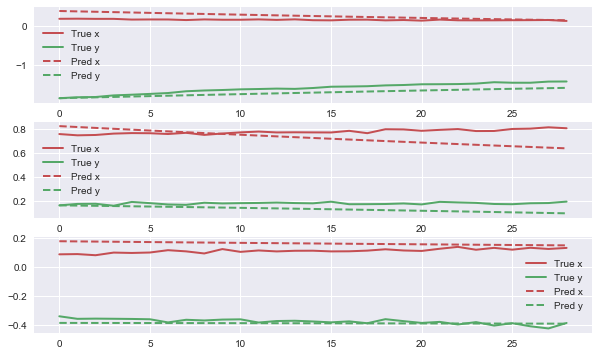

In [6]:
## check (visualize) the prediction on test data
pred = model(test_input)
pred = pred.data.numpy()
true = test_target.data.numpy()


plt.figure(figsize=(10,6))


ax = plt.subplot(311)
plt.plot(true[0,:,0], color = 'r', linewidth = 2.0, label = "True x")
plt.plot(true[0,:,1], color = 'g', linewidth = 2.0, label = "True y")
plt.plot(pred[0,:,0], color = 'r', linestyle='dashed', linewidth = 2.0, label = "Pred x")
plt.plot(pred[0,:,1], color = 'g', linestyle='dashed', linewidth = 2.0, label = "Pred y")
plt.legend()


ax = plt.subplot(312)
plt.plot(true[1,:,0], color = 'r', linewidth = 2.0, label = "True x")
plt.plot(true[1,:,1], color = 'g', linewidth = 2.0, label = "True y")
plt.plot(pred[1,:,0], color = 'r', linestyle='dashed', linewidth = 2.0, label = "Pred x")
plt.plot(pred[1,:,1], color = 'g', linestyle='dashed', linewidth = 2.0, label = "Pred y")
plt.legend()



ax = plt.subplot(313)
plt.plot(true[2,:,0], color = 'r', linewidth = 2.0, label = "True x")
plt.plot(true[2,:,1], color = 'g', linewidth = 2.0, label = "True y")
plt.plot(pred[2,:,0], color = 'r', linestyle='dashed', linewidth = 2.0, label = "Pred x")
plt.plot(pred[2,:,1], color = 'g', linestyle='dashed', linewidth = 2.0, label = "Pred y")
plt.legend()
plt.show()

In [19]:
model_parameter = {}
for name, param in model.named_parameters():

    parameter_name, parameter_value = name, param.data
    model_parameter[parameter_name] = parameter_value.numpy()

In [20]:
model_parameter

{'gru.bias_hh': array([ 1.8277534 , -0.18758793, -0.90181446, -1.7274264 , -0.02967355,
         0.43611535], dtype=float32),
 'gru.bias_ih': array([ 1.9375801 ,  0.3695756 , -1.3949728 , -1.8822006 ,  0.15053624,
        -0.24517028], dtype=float32),
 'gru.weight_hh': array([[-0.66399163, -1.8063353 ],
        [ 0.2679272 , -0.2986727 ],
        [-6.252319  ,  1.6990834 ],
        [-4.10877   , -7.257261  ],
        [-0.24269705,  0.029407  ],
        [-0.016771  , -0.08063233]], dtype=float32),
 'gru.weight_ih': array([[-1.5595917 ,  0.6105094 ],
        [ 0.53364396,  0.77218825],
        [ 0.21290304,  0.4709896 ],
        [ 0.8374885 , -0.7936469 ],
        [ 0.24470793, -0.16915609],
        [-0.24410953, -0.3224043 ]], dtype=float32),
 'linear.bias': array([-0.3340649 ,  0.22657445], dtype=float32),
 'linear.weight': array([[ 3.3056548, -2.0744567],
        [-2.4934747, -2.837051 ]], dtype=float32)}

In [32]:
class dynSys_1(object):
    
    def __init__(self, param, plot_param_x, plot_param_y, plot_param_traj_x, plot_param_traj_y, plot_param_traj_t):
        self.param = param
        self.plot_param_x = plot_param_x
        self.plot_param_y = plot_param_y
        self.plot_param_traj_x = plot_param_traj_x
        self.plot_param_traj_y = plot_param_traj_y
        self.plot_param_traj_t = plot_param_traj_t
    
    def sigmoid(self, x):
        return(1.0/(1.0 + np.exp(-x)))
    
    def sys_equation(self, h, t):
        x, y = h
       
        b_hr = self.param['gru.bias_hh'][:2]
        b_hz = self.param['gru.bias_hh'][2:4]
        b_hn = self.param['gru.bias_hh'][4:]
        
        w_hr = self.param['gru.weight_hh'][:2]
        w_hz = self.param['gru.weight_hh'][2:4]
        w_hn = self.param['gru.weight_hh'][4:]
        
        r1 = self.sigmoid(w_hr[0][0] * x + w_hr[0][1] * y + b_hr[0])
        r2 = self.sigmoid(w_hr[1][0] * x + w_hr[1][1] * y + b_hr[1])
        
        z1 = self.sigmoid(w_hz[0][0] * x + w_hz[0][1] * y + b_hz[0])
        z2 = self.sigmoid(w_hz[1][0] * x + w_hz[1][1] * y + b_hz[1])
        
        n1 = np.tanh(r1 * (w_hn[0][0] * x + w_hn[0][1] * y) + b_hn[0])
        n2 = np.tanh(r2 * (w_hn[1][0] * x + w_hn[1][1] * y) + b_hn[1])
        
        s1 = (1 - z1) * (n1 - x)
        s2 = (1 - z2) * (n2 - y)
        
        return [s1, s2]
    
    
    def arrow_plot(self):
        x = np.linspace(self.plot_param_x[0], self.plot_param_x[1], self.plot_param_x[2])
        y = np.linspace(self.plot_param_y[0], self.plot_param_y[1], self.plot_param_y[2])
        
        X, Y = np.meshgrid(x, y)
        t = 0
        u, v = np.zeros(X.shape), np.zeros(Y.shape)
        NI, NJ = X.shape
        
        for i in range(NI):
            for j in range(NJ):
                x = X[i, j]
                y = Y[i, j]
                yprime = self.sys_equation([x, y], t)
                u[i,j] = yprime[0]
                v[i,j] = yprime[1]
                
        Q = plt.quiver(X, Y, u, v, color='r')

        
        plt.xlabel('$x$')
        plt.ylabel('$y$')
        plt.xlim([self.plot_param_x[0], self.plot_param_x[1]])
        plt.ylim([self.plot_param_y[0], self.plot_param_y[1]])
        
        
    def trajectory_plot(self):
        for x0 in self.plot_param_traj_x:
            for y0 in self.plot_param_traj_y:
                n0 = [x0, y0]
                ys = odeint(self.sys_equation, n0, self.plot_param_traj_t)
                plt.plot(ys[:,0], ys[:,1], 'b-') # path
       
        plt.xlim([self.plot_param_x[0], self.plot_param_x[1]])
        plt.ylim([self.plot_param_y[0], self.plot_param_y[1]])



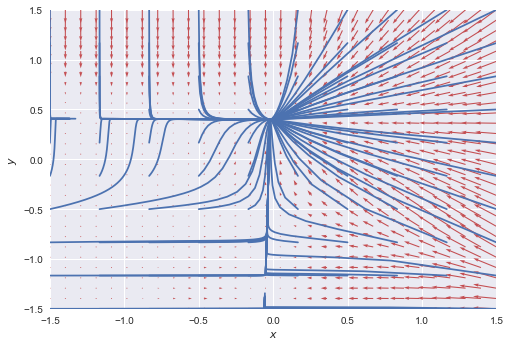

In [33]:
param = model_parameter
plot_param_x = [-1.5, 1.5, 30]
plot_param_y = [-1.5, 1.5, 30]
plot_param_traj_t = np.linspace(0, 500, 1000)
plot_param_traj_x = np.linspace(-1.5, 1.5, 10)
plot_param_traj_y = np.linspace(-1.5, 1.5, 10)

trial1 = dynSys_1(param = param, plot_param_x = plot_param_x, plot_param_y = plot_param_y, 
                plot_param_traj_x = plot_param_traj_x, plot_param_traj_y = plot_param_traj_y, 
                plot_param_traj_t = plot_param_traj_t)
trial1.arrow_plot()
trial1.trajectory_plot()
plt.show()